In [17]:
import glob 
import os
from langchain_community.llms import Ollama
import base64
from io import BytesIO
from IPython.display import HTML, display
from PIL import Image
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.prompt import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
def find_data(CK=False, JAFFE=False, FER2013=False, neutral=False):
    emo_dict = {"anger":0, "contempt":0, "disgust":0, "fear":0, "happiness":0, "neutral":0, "sadness":0, "surprise":0}
    list_paths = []

    # CK+ load
    if CK:
        for emotion in ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"]:
            if emotion is "neutral" and not neutral:
                continue
            emo_folder_path = "../Polygence/Datasets/CK+/" + emotion
            for pic_file in glob.glob(os.path.join(emo_folder_path, "*png")):
                list_paths.append([emotion, pic_file])

    # JAFFE load
    if JAFFE:
        for pic_file in glob.glob(os.path.join("../Polygence/Datasets/JAFFE", "*tiff")):
            if "AN" in pic_file[26:]:
                list_paths.append(["anger", pic_file])
            elif "DI" in pic_file[26:]:
                list_paths.append(["disgust", pic_file])
            elif "FE" in pic_file[26:]:
                list_paths.append(["fear", pic_file])
            elif "HA" in pic_file[26:]:
                list_paths.append(["happiness", pic_file])
            elif "NE" in pic_file[26:]:
                list_paths.append(["neutral", pic_file])
            elif "SA" in pic_file[26:]:
                list_paths.append(["sadness", pic_file])
            else:
                list_paths.append(["surprise", pic_file])

    #FER-2013
    if FER2013:
        FER_emo_dict = {0:"anger", 1:"disgust", 2:"fear", 3:"happiness", 4:"neutral", 5:"sadness", 6:"surprise"}
        for set in ["test/", "train/"]:
            root = "../Polygence/Datasets/FER2013/" + set
            for index, emotion in enumerate(["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]):
                emo_folder_path = root + emotion
                for pic_file in glob.glob(os.path.join(emo_folder_path, "*jpg")):
                    list_paths.append([FER_emo_dict[index], pic_file])   
    for (a,b) in list_paths:
        emo_dict[a] +=1
    print(emo_dict)
    return list_paths
def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str
def plt_img_base64(img_base64):
    """
    Display base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=False,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.1%}".format(value) for value in cf.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = correct/total

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = (12,9)

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/d6/73t68jg509l9qqjp_k_6st940000gq/T/ipykernel_3202/2600290018.py:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if emotion is "neutral" and not neutral:


In [14]:
#Function
def help(path, chain):

    file_path = path
    #print(CK[100][0])
    pil_image = Image.open(file_path)
    image_b64 = convert_to_base64(pil_image)
    #plt_img_base64(image_b64)
    input = f"""Answer the question based only on the following image:
        {image_b64}
        Question: Choose the answer that best represents the emotion on the person's face in the picture:
        0: anger
        1: contempt
        2: disgust
        3: fear
        4: happiness
        5: sadness
        6: surprise"""

    return chain.invoke({"input": input})

In [ ]:
#Setup data
CK = find_data(CK=True, JAFFE=False, FER2013=False, neutral=False)
{'anger': 45, 'contempt': 18, 'disgust': 59, 'fear': 25, 'happiness': 69, 'neutral': 0, 'sadness': 28, 'surprise': 83}
sample_paths = [CK[i] for i in [0,45,64,122,147,216,244]]
sample_images = []
for [emo, path] in sample_paths:
    sample = Image.open(path)
    sample_b64 = convert_to_base64(sample)
    sample_images.append(sample_b64)
    print(emo)
    plt_img_base64(sample_b64)


In [21]:
#Setup Chain
bakllava = Ollama(model="bakllava")

examples = [
    {
        "question": f"""Answer the question based only on the following image:
        {sample_images[0]}
        Question: Choose the answer that best represents the emotion on the person's face in the picture:
        0: anger
        1: contempt
        2: disgust
        3: fear
        4: happiness
        5: sadness
        6: surprise""",
        "answer": """0""",
    },
    {
        "question": f"""Answer the question based only on the following image:
        {sample_images[1]}
        Question: Choose the answer that best represents the emotion on the person's face in the picture:
        0: anger
        1: contempt
        2: disgust
        3: fear
        4: happiness
        5: sadness
        6: surprise""",
        "answer": """1""",
    },
    {
        "question": f"""Answer the question based only on the following image:
        {sample_images[2]}
        Question: Choose the answer that best represents the emotion on the person's face in the picture:
        0: anger
        1: contempt
        2: disgust
        3: fear
        4: happiness
        5: sadness
        6: surprise""",
        "answer": """2""",
    },
    {
        "question": f"""Answer the question based only on the following image:
        {sample_images[3]}
        Question: Choose the answer that best represents the emotion on the person's face in the picture:
        0: anger
        1: contempt
        2: disgust
        3: fear
        4: happiness
        5: sadness
        6: surprise""",
        "answer": """3""",
    },
    {
        "question": f"""Answer the question based only on the following image:
        {sample_images[4]}
        Question: Choose the answer that best represents the emotion on the person's face in the picture:
        0: anger
        1: contempt
        2: disgust
        3: fear
        4: happiness
        5: sadness
        6: surprise""",
        "answer": """4""",
    },
    {
        "question": f"""Answer the question based only on the following image:
        {sample_images[5]}
        Question: Choose the answer that best represents the emotion on the person's face in the picture:
        0: anger
        1: contempt
        2: disgust
        3: fear
        4: happiness
        5: sadness
        6: surprise""",
        "answer": """5""",
    },
    {
        "question": f"""Answer the question based only on the following image:
        {sample_images[6]}
        Question: Choose the answer that best represents the emotion on the person's face in the picture:
        0: anger
        1: contempt
        2: disgust
        3: fear
        4: happiness
        5: sadness
        6: surprise""",
        "answer": """6""",
    },
]

example_prompt = PromptTemplate(
    input_variables=["question", "answer"], template="Question: {question}\n{answer}"
)

prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="{input}",
    input_variables=["input"],
)
output_parser = StrOutputParser()

chain = prompt | bakllava | output_parser

In [22]:
emo_dict = {"anger":0, "contempt":1, "disgust":2, "fear":3, "happiness":4, "sadness":5, "surprise":6}
heat_matrix = [[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]]

correct = 0
total = 0

for emo, path in CK:
    emo_hat = help(path, chain)
    if emo_hat in [str(i) for i in range(7)]: 
        heat_matrix[emo_dict[emo]][int(emo_hat)] +=1
        if int(emo_hat)==emo_dict[emo]:
            correct +=1
    total +=1 
    print(emo, emo_hat)
    if total%10==0:
        print(total, correct/total)

anger 1
anger 4
anger 3
anger 3
anger 3
anger 4
anger 2
anger 3
anger 3
anger 4
10 0.0
anger 3
anger 2
anger 3
anger 4
anger 4
anger 0
anger 0
anger 4
anger 3
anger 2
20 0.1
anger 4
anger 0
anger 4
anger 4
anger 4
anger 3
anger 4
anger 4
anger 4
anger 4
30 0.1
anger 4
anger 3
anger 4
anger 4
anger 0
anger 4
anger 2
anger 0
anger 4
anger 3
40 0.125
anger 4
anger 4
anger 3
anger 4
anger 0
contempt 3
contempt 0
contempt 4
contempt 3
contempt 4
50 0.12
contempt 3
contempt 4
contempt 2
contempt 4
contempt 4
contempt 2
contempt 4
contempt 4
contempt 4
contempt 4
60 0.1
contempt 4
contempt 0
contempt 4
disgust 1
disgust 4
disgust 0
disgust 4
disgust 0
disgust 3
disgust 1
70 0.08571428571428572
disgust 0
disgust 0
disgust 4
disgust 1
disgust 4
disgust 4
disgust 2
disgust 3
disgust 3
disgust 4
80 0.0875
disgust 3
disgust 0
disgust 4
disgust 4
disgust 0
disgust 4
disgust 0
disgust 4
disgust 0
disgust 3
90 0.07777777777777778
disgust 4
disgust 4
disgust 4
disgust 3
disgust 1
disgust 3
disgust 2
d

[[0.133 0.022 0.088 0.266 0.488 0.    0.   ]
 [0.111 0.    0.111 0.166 0.611 0.    0.   ]
 [0.186 0.084 0.05  0.203 0.474 0.    0.   ]
 [0.2   0.04  0.08  0.12  0.56  0.    0.   ]
 [0.159 0.072 0.028 0.173 0.521 0.014 0.014]
 [0.107 0.107 0.071 0.214 0.464 0.035 0.   ]
 [0.168 0.024 0.012 0.156 0.566 0.024 0.012]]
0.1529051987767584


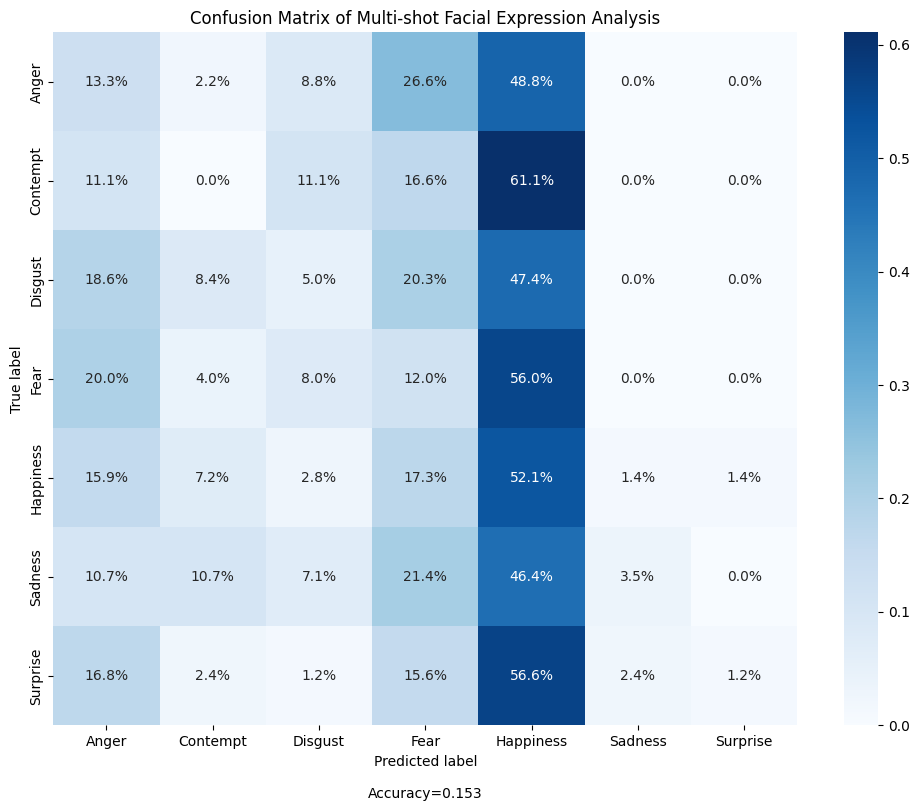

In [26]:
def truncate(n, decimals=0):
    multiplier = 10**decimals
    return int(n * multiplier) / multiplier

counts = [45, 18, 59,25,69,28,83]

heatmap_matrix = [[truncate(m/counts[n],3) for m in i] for n,i in enumerate(heat_matrix)]
make_confusion_matrix(np.array(heatmap_matrix), title="Confusion Matrix of Multi-shot Facial Expression Analysis", categories=["Anger", "Contempt", "Disgust", "Fear", "Happiness", "Sadness", "Surprise"])

print(np.array(heatmap_matrix))
print(correct/total)

In [27]:
totals = [0,0,0,0,0,0,0]
for i in heat_matrix:
    totals = [a+b for (a,b) in list(zip(totals, i))]
print(totals)
print(heat_matrix)

[52, 17, 16, 61, 171, 4, 2]
[[6, 1, 4, 12, 22, 0, 0], [2, 0, 2, 3, 11, 0, 0], [11, 5, 3, 12, 28, 0, 0], [5, 1, 2, 3, 14, 0, 0], [11, 5, 2, 12, 36, 1, 1], [3, 3, 2, 6, 13, 1, 0], [14, 2, 1, 13, 47, 2, 1]]
